In [247]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
from myUtils import *

# rootPath = "../../results/scenario/geothermal"
# rootPath = "../../results/scenario/biogas"
# rootPath = "../../results/scenario/PHS"
rootPath = "../../results/scenario/PHS"
# rootPath = "../../results/scenario/battery"
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.color_palette("muted", 14)
%matplotlib inline

# n = pypsa.Network("../../results/base/base27Node2045/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nMean = pypsa.Network(rootPath + "-mean/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nOptimist = pypsa.Network(rootPath + "-optimist/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network(rootPath + "/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")

# n = pypsa.Network("../../results/scenario/h2-best/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario/h2-de/postnetworks/base_s_20_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario-old/h2-idea/postnetworks/base_s_27_lc1_3H_3H_2045.nc")
n = pypsa.Network("../../results/scenario/h2_good/networks/base_s_27_3H_3H_2045.nc")


INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


```
1 kW= 1e3 W               1 KWH = 1e3 WH             1 Tsd EUR = 1e3 EUR
1 MW = 1e6 W = 1 MW       1 MWH = 1e6 WH = 1 MWH     1 Mio.EUR = 1e6 EUR
1 GW = 1e9 W = 1e3 MW     1 GWH = 1e9 WH = 1e3 MWH   1 Mrd.EUR = 1e9 EUR
1 TW = 1e12 W = 1e6 MW    1 TWH = 1e12 WH = 1e6 MWH  1 Bio.EUR = 1e12 EUR


```

72.06527760185882
5.345417262919869


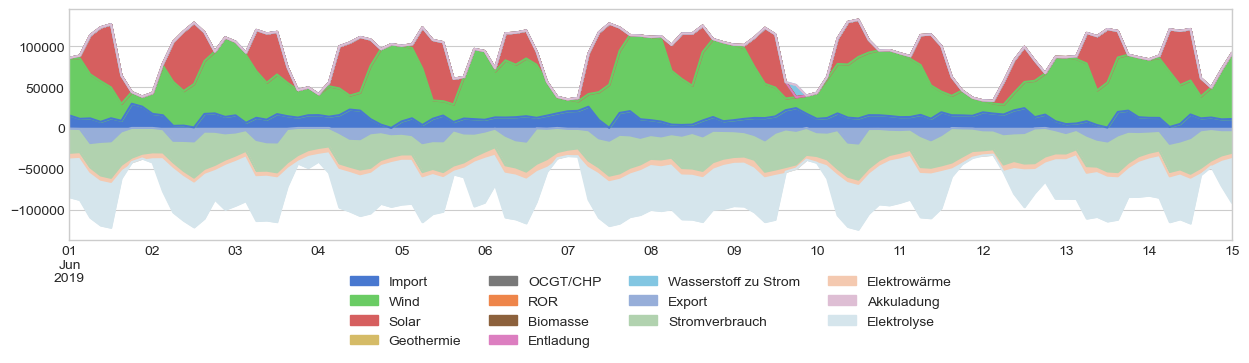

In [225]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


df = pd.DataFrame(index = n.snapshots)

# supply

importLinkIds = utils.de_import_elec_grouper(n, 'Link').tolist()
importLinIds = utils.de_import_elec_grouper(n, 'Line').tolist()
importLineRIDS = utils.de_import_elec_reverse_grouper(n, 'Line').tolist()

df['Import'] = - n.links_t.p1[importLinkIds].sum(axis=1) \
  - n.lines_t.p1[importLinIds].clip(upper=0).sum(axis=1) \
  - n.lines_t.p0[importLineRIDS].clip(upper=0).sum(axis=1)


generatorGeneratorIds =  utils.de_generator_grouper(n, 'Generator').tolist()
generatorLinkIds =  utils.de_generator_grouper(n, 'Link').tolist()


windGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_wind_generator_grouper)
df['Wind'] =  windGeneratorP.sum(axis=1)
pvGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_pv_generator_grouper)
df['Solar'] =  pvGeneratorP.sum(axis=1)
co2GeneratorP = - utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_co2_generator_grouper)
biomassGeneratorP = - utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_biomass_generator_grouper)

rorGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_ror_generator_grouper)
geothermalGeneratorP = utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_geothermal_generator_grouper)

df['Geothermie'] = - geothermalGeneratorP.sum(axis=1)

df['OCGT/CHP'] =  co2GeneratorP.sum(axis=1) 
df['ROR'] =  rorGeneratorP.sum(axis=1) 
df['Biomasse']=biomassGeneratorP.sum(axis=1)

# demand

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
df['Entladung'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1) \
  + n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)

ids = utils.de_h2_dispatch_grouper(n, 'Link').tolist()
df['Wasserstoff zu Strom'] = - n.links_t.p1[ids].sum(axis=1)
# use
exportLinkIds = utils.de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = utils.de_export_elec_grouper(n, 'Line').tolist()

df['Export'] = - n.links_t.p0[exportLinkIds].sum(axis=1) \
  - n.lines_t.p0[exportLinIds].clip(lower=0).sum(axis=1) \
  # - n.lines_t.p1[importLineRIDS].clip(upper=0).sum(axis=1)


useLoadIds = utils.de_elec_use_grouper(n, 'Load').tolist()
useLinesWasteIds = utils.getIndexSeries(n.df('Line'), utils.getIndexDeInnerCarrier(n.df('Line'), 'AC'))
distributionP0 = utils.getNTimePropByGroup(n, 'Link', 'p0', utils.de_elec_distrbution_use_grouper) 
distributionP1 = utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_elec_distrbution_use_grouper) 



df['Stromverbrauch'] = - n.loads_t.p[useLoadIds].sum(axis=1)  \
  - utils.getNTimePropByGroup(n, 'Link', 'p2', utils.de_elec_methanol_use).sum(axis=1) \
  - (n.lines_t.p0[useLinesWasteIds] + n.lines_t.p1[useLinesWasteIds]).sum(axis=1) \
  - (distributionP0 + distributionP1).sum(axis=1)
useLinkIds = utils.de_elec_use_grouper(n, 'Link').tolist()   
df['Elektrowärme'] =  -n.links_t.p0[useLinkIds].clip(lower=0).sum(axis=1)

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()


storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
useElectrolysisIds = utils.de_h2_Electrolysis_grouper(n, 'Link').tolist()
df['Akkuladung'] =  n.storage_units_t.p[storeStorageIds].clip(upper=0).sum(axis=1)\
  + n.stores_t.p[storeStoreIds].clip(upper=0).sum(axis=1) 

df['Elektrolyse'] = - n.links_t.p0[useElectrolysisIds].sum(axis=1) 

# total_use = (df['export'] + df['use']  + df['heat'])
# total_produce= (df['import'] + df['PV generator'] + df['dispatch'])
print(n.statistics.capex(groupby="de_grouper").sum() / 1e9) # 71
print(n.statistics.opex(groupby="de_grouper").sum() / 1e9) # 5

colors = {
  'Import': '#4878D0',
  'Wasserstoff zu Strom': '#82C6E2',
  'Entladung': '#DC7EC0',
  
  'Wind': '#6ACC64',
  'Solar': '#D65F5F',
  'Geothermie': '#D5BB67',
  'OCGT/CHP': '#797979',
  'ROR': '#EE854A',
  'Biomasse': '#8C613C',

  'Export': '#97AED9',
  'Elektrolyse': '#D5E5EC',
  'Akkuladung': '#DEBED4',

  'Stromverbrauch': '#B1D2AF',
  'Elektrowärme': '#F4C9B0',
  
 
  
}

ax = df['2019-6-1 00:00:00': '2019-6-15 00:00:00'].plot(kind='area', figsize=(15,3), color=colors )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, frameon=False)
ax.set_xlabel('')

area_colors = [polygon.get_facecolor() for polygon in ax.collections]
area_colors_rgb = [color[:3] for color in area_colors]


plt.show()


In [223]:
generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
  # print(biomass)
s = pd.concat([generators, generatorLinks,h2s])
s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
s['Solar'] = s['solar'] + s['solar-hsat']
s['Onwind'] = s['onwind']
  

s['Solardach'] = s['solar rooftop']
s['Erdgas CHP'] = s['urban central CHP']
s['Geothermal'] = s.get('geothermal organic rankine cycle', 0)
s['Biomasse CHP'] = biomass.p_nom_opt.sum() 
s['Gesamt'] = s.sum()
  
s = s.reindex(['Onwind', 'Offwind', 'Solar', 'Solardach','OCGT','Erdgas CHP', 'Geothermal','H2 Fuel Cell', 'H2 turbine', 'Biomasse CHP', 'ror', 'Gesamt'])
s

carrier
Onwind          78.95093
Offwind         78.32878
Solar           50.28731
Solardach      100.78250
OCGT             0.00044
Erdgas CHP       0.00052
Geothermal       0.00000
H2 Fuel Cell     0.00006
H2 turbine     135.85202
Biomasse CHP     0.00000
ror                  NaN
Gesamt         752.55262
Name: p_nom_opt, dtype: float64

In [224]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    n.statistics.capex().sum() / 1e9,
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,

    n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
    "CAPEX(inkl. Nachbarländer)",
    "CAPEX",
    "investierte CAPEX",
    "OPEX",

    "Strom CAPEX",
    "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(n),
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

# caepx_base = df.loc['CAPEX', 'Base']
# caepx_changes = (df.loc['CAPEX', ['Mean', 'Optimist', 'Best']] - caepx_base) / caepx_base * 100

# elc_caepx_base = df.loc['Strom CAPEX', 'Base']
# elc_caepx_changes = (df.loc['Strom CAPEX', ['Mean', 'Optimist', 'Best']] - elc_caepx_base) / elc_caepx_base * 100

# table = utils.dataframe_to_table(df)
# print(table)
# print(caepx_changes)
# print(elc_caepx_changes)

print(df)

6 6 6
                                Base
Name                                
CAPEX(inkl. Nachbarländer) 613.20455
CAPEX                       72.06528
investierte CAPEX           60.76954
OPEX                         5.34542
Strom CAPEX                 33.60903
Strom Opex                   0.15167


In [281]:
n1 = pypsa.Network("../../results/scenario/h2_good/networks/base_s_27_3H_3H_2045.nc")
n2 = pypsa.Network("../../results/scenario/flex_mean/networks/base_s_27_3H_3H_2045-1.nc")

series1 = utils.getNByGroup(n1,'Generator', utils.de_pv_generator_grouper)['p_nom_max']
series2 =  utils.getNByGroup(n2,'Generator', utils.de_pv_generator_grouper)['p_nom_max']
df = pd.concat([series1, series2], axis=1)
print (df)

INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045-1.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


                       p_nom_max    p_nom_max
Generator                                    
DE0 0 solar          92426.15889  92426.15889
DE0 1 solar         132734.15294 132734.15294
DE0 2 solar         122319.53420 122319.53420
DE0 3 solar         161300.32981 161300.32981
DE0 4 solar         198513.45427 198513.45427
DE0 5 solar         111357.47486 111357.47486
DE0 6 solar         166426.34813 166426.34813
DE0 7 solar         101141.99500 101141.99500
DE0 0 solar-hsat     80283.89880  80283.89880
DE0 1 solar-hsat    115296.52892 115296.52892
DE0 2 solar-hsat    106250.10519 106250.10519
DE0 3 solar-hsat    140109.89433 140109.89433
DE0 4 solar-hsat    172434.23577 172434.23577
DE0 5 solar-hsat     96728.15954  96728.15954
DE0 6 solar-hsat    144562.49456 144562.49456
DE0 7 solar-hsat     87854.71330  87854.71330
DE0 0 solar rooftop  24629.33336  24629.33336
DE0 1 solar rooftop  13439.61032  13439.61032
DE0 2 solar rooftop  16439.81713  16439.81713
DE0 3 solar rooftop  17955.12152  